# <center> <h1> hyperparameter tuning Logistic Regression </h1> </center>

In [163]:
# Import library
import pandas as pd 
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt

In [104]:
datos = pd.read_csv("heart.csv")
datos.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


## Duplicate values

In [105]:
datos[datos.duplicated()]
# drop duplicate values 
datos.drop_duplicates(keep='first',inplace=True)

## Scaling data

In [106]:
# copy the data 
df_copy = datos.copy()

from sklearn.preprocessing import MinMaxScaler
#Create objectscaler 
scaler = MinMaxScaler()
# Fit data
df_scaled = scaler.fit_transform(df_copy)
#convert array to data frame
df_scaled  = pd.DataFrame(df_scaled)
# Reset labels to data frame
df_scaled.columns = datos.columns
df_scaled.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.0,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,0.666667,1.0


# Configuracion de variables test y train

In [107]:
# define the variable 'x' and 'y'

X = df_scaled.drop('output', axis=1)
y = df_copy['output']

In [108]:
# Spliting data train & test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create models

## load models and metrics load models and metrics 

In [109]:
# import classification model
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
from sklearn import metrics

# Metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

##  hyperparameter tuning

Let's try to get the best parameter for our model 

In [110]:
log_moddel = LogisticRegression( )

# Definir la distribución de hiperparámetros para ajustar
params = {'C' : loguniform(0.001, 1000),
          'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'saga', 'sag'],
          'max_iter': [100, 500, 1000, 10000]
          }

log_moddel = RandomizedSearchCV(LogisticRegression(), params, cv=5, random_state = 42)
log_moddel.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002A8B1CC5C00>,
                                        'max_iter': [100, 500, 1000, 10000],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'saga',
                                                   'sag']},
                   random_state=42)

In [111]:
# get beter params
print(f"{log_moddel.best_params_}")
print(f"The best score: {log_moddel.best_score_}")

{'C': 47.659118086808384, 'max_iter': 100, 'solver': 'lbfgs'}
The best score: 0.83843537414966


# Importance of features in the classification model

In [112]:
# Adjust final model with best parameters
model_final = LogisticRegression(C = log_moddel.best_params_['C'],
                                 solver = log_moddel.best_params_['solver'],
                                 max_iter= log_moddel.best_params_['max_iter'])

model_final.fit(X_train, y_train)

LogisticRegression(C=47.659118086808384)

In [122]:
# make model predictions about the test
prediccion_modelo = model_final.predict(X_test)

# score accuracy predictions, the correct value is sent on the estimated
print(f'cv score = {cross_val_score(model_final, X, y, cv= 10).mean()}')
print(f'accuracy = {metrics.accuracy_score(y_test, prediccion_modelo)}')

cv score = 0.8210752688172043
accuracy = 0.8032786885245902


## Ploting

In [123]:
print(model_final.coef_)
print('='*80)
print(model_final.feature_names_in_)

[[ 0.3412697  -1.88255889  2.73829372 -1.79469799 -3.44827894  0.24554837
   0.35223311  3.43307677 -0.84829341 -3.47068498  0.95748902 -3.85613119
  -2.40743859]]
['age' 'sex' 'cp' 'trtbps' 'chol' 'fbs' 'restecg' 'thalachh' 'exng'
 'oldpeak' 'slp' 'caa' 'thall']


In [115]:
 weight = pd.Series(model_final.coef_[0],
                    index=X.columns.values)

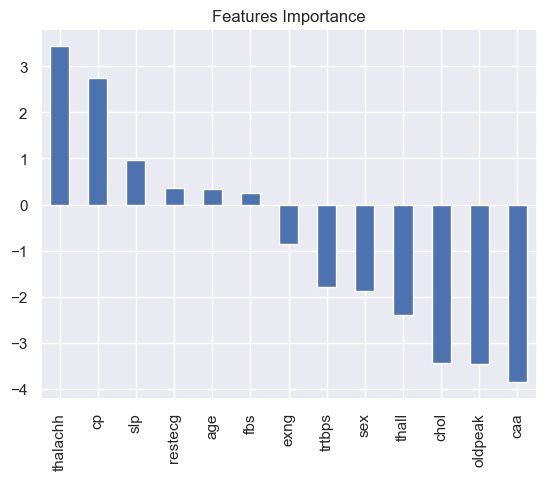

In [116]:
# Se grafican las variables 
weight.sort_values(ascending=False)[:].plot(kind='bar')
plt.title('Features Importance')
plt.show()

# Confusion Matrix

<Figure size 1100x1100 with 0 Axes>

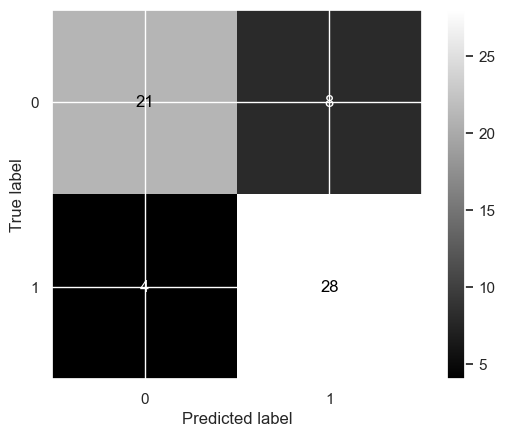

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig = plt.figure(figsize=(11,11))
cm = confusion_matrix(y_test, prediccion_modelo,  labels = model_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_final.classes_)
disp.plot(cmap='gray')
plt.show()

In [167]:
# save model

import pickle
pickle.dump(model_final, open("Logit_cancer.pkl", "wb"))